In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
def clean_df(filename):
    out = pd.read_csv(filename, encoding="ISO-8859-1", names=['polarity', 'id', 'date', 'query', 'user', 'text'])
    out = out.drop(labels=['id', 'date', 'query', 'user'], axis = 1)
    out = out.loc[out['polarity'] != 2]

    return out

In [3]:
train = clean_df('../trainingandtestdata/training.1600000.processed.noemoticon.csv')
test = clean_df('../trainingandtestdata/testdata.manual.2009.06.14.csv')


In [4]:
data = pd.concat([train, test])
data = data.sample(n=10000)

In [5]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [6]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(data['text'].values)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 19009 unique tokens.


In [7]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = data['polarity']

Shape of data tensor: (10000, 250)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(9000, 250) (9000,)
(1000, 250) (1000,)


In [11]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
127/127 [==============================] - 170s 1s/step - loss: -14.9907 - accuracy: 0.0021 - val_loss: -24.7740 - val_accuracy: 0.0000e+00
Epoch 2/10
127/127 [==============================] - 134s 1s/step - loss: -30.7923 - accuracy: 0.0000e+00 - val_loss: -38.4910 - val_accuracy: 0.0000e+00
Epoch 3/10
127/127 [==============================] - 96s 759ms/step - loss: -43.8146 - accuracy: 0.0000e+00 - val_loss: -51.6008 - val_accuracy: 0.0000e+00
Epoch 4/10
127/127 [==============================] - 70s 554ms/step - loss: -56.4769 - accuracy: 0.0000e+00 - val_loss: -64.5893 - val_accuracy: 0.0000e+00
Epoch 5/10
127/127 [==============================] - 69s 543ms/step - loss: -68.9935 - accuracy: 0.0000e+00 - val_loss: -77.3647 - val_accuracy: 0.0000e+00
Epoch 6/10
127/127 [==============================] - 69s 547ms/step - loss: -81.4927 - accuracy: 0.0000e+00 - val_loss: -90.3378 - val_accuracy: 0.0000e+00
Epoch 7/10
127/127 [==============================] - 88s 693ms/st

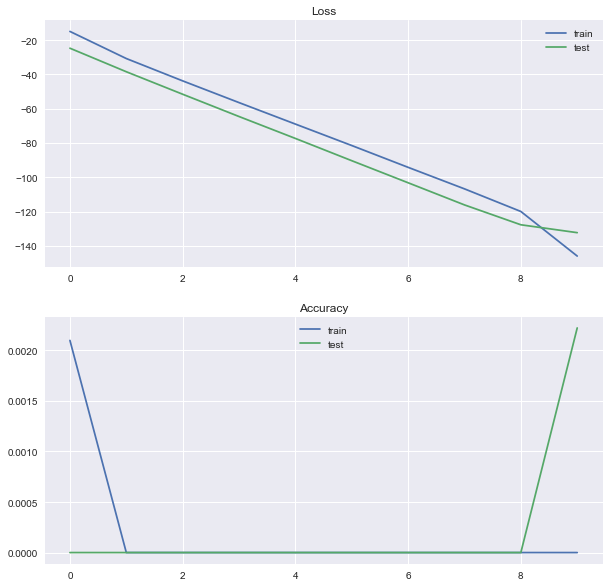

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].set_title('Loss')
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].legend()